# Lab 1 : First order methods on regression models

#### Authors: A. Gramfort, R. Gower, P. Ablin, M. Massias

## Aim

The aim of this material is to code
- proximal gradient descent (PGD)
- accelerated gradient descent (APGD)

for
- linear regression
- logistic regression

models.

The proximal operators we will use are the
- L2 penalization
- L1 penalization

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work using the **moodle platform**. Please check the deadline on moodle!
- This means that **each student in the pair sends the same file**
- The **name of the file must be** constructed as in the next cell

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [ ]:
# Change here using YOUR first and last names
fn1 = "nicolas"
ln1 = "saint"
fn2 = "matthis"
ln2 = "guerin"

filename = "_".join(map(lambda s: s.strip().lower(),
                        ["lab1", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

lab1_saint_nicolas_and_guérrin_matthis.ipynb


In [ ]:
## to embed figures in the notebook
%matplotlib inline

## Part 0 : Introduction

We'll start by generating sparse vectors and simulating data

### Getting sparse coefficients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=2)  # to have simpler print outputs with numpy

Text(0.5, 1.0, 'Parameters / Coefficients')

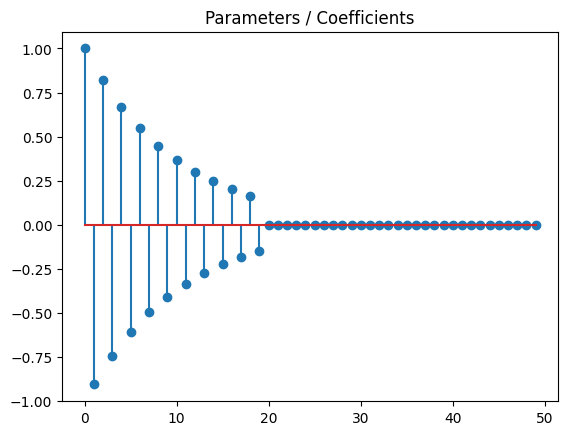

In [ ]:
n_features = 50
n_samples = 1000
idx = np.arange(n_features)
coefs = ((-1) ** idx) * np.exp(-idx / 10.)
coefs[20:] = 0.
plt.stem(coefs)
plt.title("Parameters / Coefficients")

### Functions for the simulation of the models

In [ ]:
from numpy.random import multivariate_normal
from scipy.linalg import toeplitz


def simu_linreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a linear regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
         Correlation between features i and j is corr^|i - j|


    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    # Construction of a covariance matrix
    cov = toeplitz(corr ** np.arange(0, n_features))
    # Simulation of features
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    # Simulation of the labels
    b = A.dot(coefs) + np.random.randn(n_samples)
    return A, b


def sigmoid(t):
    """Sigmoid function"""
    return 1. / (1. + np.exp(-t))


def simu_logreg(coefs, n_samples=1000, corr=0.5):
    """Simulation of a logistic regression model

    Parameters
    ----------
    coefs : `numpy.array`, shape (n_features,)
        Coefficients of the model

    n_samples : `int`, default=1000
        Number of samples to simulate

    corr : `float`, default=0.5
        Correlation between features i and j is corr^|i - j|

    Returns
    -------
    A : `numpy.ndarray`, shape (n_samples, n_features)
        Simulated features matrix. It samples of a centered Gaussian
        vector with covariance given by the Toeplitz matrix

    b : `numpy.array`, shape (n_samples,)
        Simulated labels
    """
    cov = toeplitz(corr ** np.arange(0, n_features))
    A = multivariate_normal(np.zeros(n_features), cov, size=n_samples)
    p = sigmoid(A.dot(coefs))
    b = np.random.binomial(1, p, size=n_samples)
    b = 2 * b - 1
    return A, b

## Generate the data

In [ ]:
A, b = simu_linreg(coefs)
# A, b = simu_logreg(coefs)  # uncomment when you want to test logistic regression

## Part 1 : Proximal operators

We remind that the proximal operator of a function $R$ is given by:

$$
\text{prox}_{(\lambda \,R)}(x) = \arg\min_z \left\{ \frac{1}{2} \Vert x - z\Vert_2^2 + \lambda \,R(z) \right\}.
$$


We have in mind to use the following cases

- L2 penalization, where $R(z) = \frac{1}{2} \|z\|_2^2$
- L1 penalization, where $R(z) =  \|z|\|_1$

where $\lambda > 0$ is a regularization parameter.

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Code a function that computes $R(x)$ in both cases and $\text{prox}_{\lambda\, R}(x)$ for L2 and  L1 penalization (use the slides of the first course to get the formulas), using the prototypes given below</li>
      <li>Visualize the functions applied element wise by the proximity operators of the L2 and L1
    </li>
    </ul>
</div>

In [ ]:
def prox_L1(x, lmbd):
    """Proximal operator for the L1 at x"""
    return np.sign(x) * np.maximum(np.abs(x) - lmbd, 0)

def L1_norm(x, lmbd):
    """Value of the L1 penalization at x"""
    return lmbd * np.linalg.norm(x, ord=1)

def prox_L2(x, lmbd):
    """Proximal operator for the L2 at x"""
    return x / (1 + lmbd)

def L2_norm(x, lmbd):
    """Value of the L2 penalization at x"""
    return 0.5 * lmbd * np.linalg.norm(x, ord=2)**2


## Visualization

We are now going to visualize the effect of the proximity operators on coefficients.

(-2.0, 2.0)

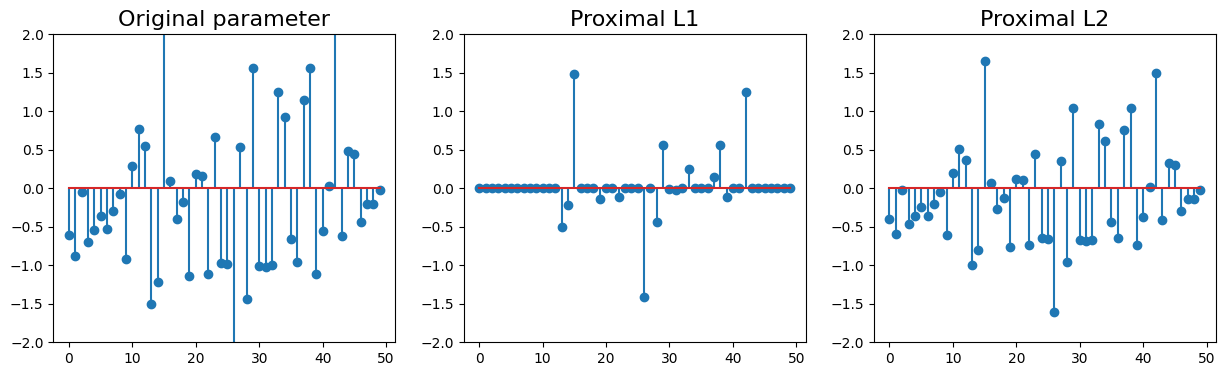

In [ ]:
x = np.random.randn(50)
l_l1 = 1.
l_l2 = 0.5

plt.figure(figsize=(15.0, 4.0))
plt.subplot(1, 3, 1)
plt.stem(x)
plt.title("Original parameter", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 2)
plt.stem(prox_L1(x, lmbd=l_l1))
plt.title("Proximal L1", fontsize=16)
plt.ylim([-2, 2])
plt.subplot(1, 3, 3)
plt.stem(prox_L2(x, lmbd=l_l2))
plt.title("Proximal L2", fontsize=16)
plt.ylim([-2, 2])

<div class="alert alert-success">
    <b>Question</b>:
     <ul>
      <li>Comment what you observe (1 or 2 sentences).</li>
    </ul>
</div>

We observe that for :

- Proximal L1 tend to put a lot of features of the matrix at 0, it is due as we have seen in the course to the sparcity of the lasso.
- Proximal L2 rather tend to reduce the features values. It looks like normalisation as the outliers reduce a lot more.

## Part 2: Gradients

The problems we want to minimize take the form:
$$
\arg\min_x f(x) + \lambda \,R(x)
$$
where $f$ is $L$-smooth and $R$ has a simple proximal operator.

Consider the following cases:

**Linear regression**, where
$$
f(x) = \frac{1}{2n} \sum_{i=1}^n (b_i - a_i^\top x)^2 = \frac{1}{2 n} \| b - A x \|_2^2,
$$
where $n$ is the sample size, $b = [b_1 \cdots b_n]$ is the vector of labels and $A = [a_1,\ldots, a_n]^{\top} \in \mathbb{R}^{n \times d}$ is the matrix of samples.

**Logistic regression**, where
$$
f(x) = \frac{1}{n} \sum_{i=1}^n \log(1 + \exp(-b_i a_i^\top x)),
$$
where $n$ is the sample size, and where labels $b_i \in \{ -1, 1 \}$ for all $i$.

We need to be able to compute $f$ and its gradient

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute on paper the gradient $\nabla f$ of $f$ for both cases (linear and logistic regression)</li>
      <li>Code a function that computes $f$ and its gradient $\nabla f$ in both cases, using the prototypes below.</li>
      <li>Check that these functions are correct by numerically checking the gradient, using the function ``<a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.check_grad.html">check_grad</a>`` from ``scipy.optimize``. Remark: use the functions `simu_linreg` and `simu_logreg` to simulate data according to the right model</li>
    </ul>
</div>

In [ ]:
from scipy.optimize import check_grad

# Linear Regression
def loss_linreg(x):
    """Least-squares loss"""
    n = A.shape[0]
    residual = A.dot(x) - b
    loss = 0.5 * np.linalg.norm(residual)**2 / n
    return loss

def grad_linreg(x):
    """Least-squares gradient"""
    n = A.shape[0]
    residual = A.dot(x) - b
    gradient = A.T.dot(residual) / n
    return gradient

# Logistic Regression
def loss_logreg(x):
    """Logistic loss"""
    n = A.shape[0]
    z = A.dot(x) * b
    loss = np.mean(np.log(1 + np.exp(-z)))
    return loss

def grad_logreg(x):
    """Logistic gradient"""
    n = A.shape[0]
    z = A.dot(x) * b
    gradient = -np.mean((np.exp(-z) / (1 + np.exp(-z))) * (A.T * b), axis=1)
    return gradient


def check_linear_regression_gradient(coefs, n_samples=100, corr=0.5):
    A, b = simu_linreg(coefs, n_samples, corr)
    x = np.random.randn(A.shape[1])  # Random initial point
    linear_grad_err = check_grad(loss_linreg, grad_linreg, x)
    print(f"Linear Regression Gradient Error: {linear_grad_err}")


def check_logistic_regression_gradient(coefs, n_samples=100, corr=0.5):
    A, b = simu_logreg(coefs, n_samples, corr)
    x = np.random.randn(A.shape[1])  # Random initial point
    logistic_grad_err = check_grad(loss_logreg, grad_logreg, x)
    print(f"Logistic Regression Gradient Error: {logistic_grad_err}")


check_linear_regression_gradient(coefs)
check_logistic_regression_gradient(coefs)



Linear Regression Gradient Error: 4.155423731779564e-06
Logistic Regression Gradient Error: 1.9910361335816614e-07


## Part 3: Solvers

We know have a function to compute $f$, $\nabla f$ and $R$ and $\text{prox}_R$.

We want now to code the PGD and APGD solvers to minimize

$$
\arg\min_x f(x) + \lambda \, R(x)
$$

where $\lambda >0$ is the regularization parameter

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Implement functions that compute the Lipschitz constants for linear and
  logistic regression losses. Note that the operator norm of a matrix can
  be computed using the function <a href="https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.norm.html">numpy.linalg.norm</a> (read the documentation
  of the function)</li>
      <li>Finish the functions `PGD` and `APGD` below that implements the
  PGD(Proximal Gradient Descent) and APGD (Accelerated Proximal
  Gradient Descent) algorithms</li>
    </ul>
</div>

In [ ]:
# TO BE COMPLETED

# Calculate the smoothness constant for L2 + L2 regularizer
def smoothness_const_linreg(A):
    """Lipschitz constant for linear squares loss"""
    n_samples, _ = A.shape
    L = np.linalg.norm(A, ord=2) ** 2 / n_samples
    return L

# Calculate the smoothness constant for Logistic loss + L2 regularizer
def smoothness_const_logreg(A):
    """Lipschitz constant for logistic loss"""
    n_samples, _ = A.shape
    L = np.linalg.norm(A, ord=2) ** 2 / (4 * n_samples)
    return L

def PGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    n_samples, n_features = A.shape

    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    if verbose:
        print("Lauching PGDsolver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####

        # Gradient descent step
        x_new[:] = prox_R(x - step * grad_f(x), step * lmbd)

        x[:] = x_new

        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8),
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
    return x, objectives, errors

In [ ]:
# TO BE COMPLETED

def APGD(x0, f, grad_f, R, prox_R, step, lmbd=0., n_iter=50,
         x_true=coefs, verbose=True):
    """Accelerated Proximal gradient descent algorithm
    """
    x = x0.copy()
    x_new = x0.copy()
    # An extra variable is required for APGD
    z = x0.copy()
    n_samples, n_features = A.shape
    # estimation error history
    errors = []
    # objective history
    objectives = []
    # Current estimation error
    err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
    errors.append(err)
    # Current objective
    obj = f(x) + R(x, lmbd)
    objectives.append(obj)
    t = 1.
    t_new = 1.
    if verbose:
        print("Lauching APGD solver...")
        print(' | '.join([name.center(8) for name in ["it", "obj", "err"]]))
    for k in range(n_iter + 1):

        #### TODO ####

        # Store the previous values of x and t
        x_prev = x.copy()
        t_prev = t
        # Update x using the proximal operator and the extra variable z
        z = prox_R(x - step * grad_f(x), step * lmbd)
        t = (1. + np.sqrt(1. + 4. * t_prev * t_prev)) / 2.
        x = z + (t_prev - 1.) / t * (z - x_prev)

        obj = f(x) + R(x, lmbd)
        err = np.linalg.norm(x - x_true) / np.linalg.norm(x_true)
        errors.append(err)
        objectives.append(obj)
        if k % 10 == 0 and verbose:
            print(' | '.join([("%d" % k).rjust(8),
                              ("%.2e" % obj).rjust(8),
                              ("%.2e" % err).rjust(8)]))
    return x, np.array(objectives), np.array(errors)

## Algorithms comparison and numerical experiments

In [ ]:
# Some definitions before launching the algorithms
x0 = np.zeros(n_features)
n_iter = 200
lmbd = 1e-2

<div class="alert alert-success">
    <b>Questions</b>:
     <ul>
      <li>Compute a precise minimum and a precise minimizer of the linear regression with L2
  penalization problem using the parameters give above. This can be done by using APGD with
  1000 iterations.</li>
    <li>Compare the convergences of PGD and APGD, in terms of distance to the minimum and
  distance to the minimizer. Do your plots using a logarithmic scale of the y-axis.</li>
    </ul>
</div>

In [ ]:
# Define the smoothness constant for linear regression
step = 1 / smoothness_const_linreg(A)

n_iter= 1000

# Use APGD to find the minimum and minimizer
apgd_minimizers, apgd_min, agpd_err = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2, step, lmbd, n_iter, x_true=coefs, verbose=False)

print(f"Precise Minimum Value: {apgd_min[-1]}")
print(f"Precise Minimizer: {apgd_minimizers}")

Precise Minimum Value: 0.5463023870100874
Precise Minimizer: [ 0.96 -0.87  0.87 -0.72  0.69 -0.63  0.62 -0.52  0.46 -0.41  0.35 -0.27
  0.26 -0.22  0.15 -0.19  0.25 -0.22  0.18 -0.18 -0.02  0.03 -0.02  0.03
  0.03 -0.04  0.01 -0.01 -0.01  0.05 -0.01 -0.06  0.03 -0.03  0.01 -0.03
 -0.01 -0.01  0.02 -0.06  0.05 -0.02 -0.01 -0.02 -0.02 -0.01  0.02 -0.07
  0.05 -0.03]


### Comparing the convergences PGD - APGD

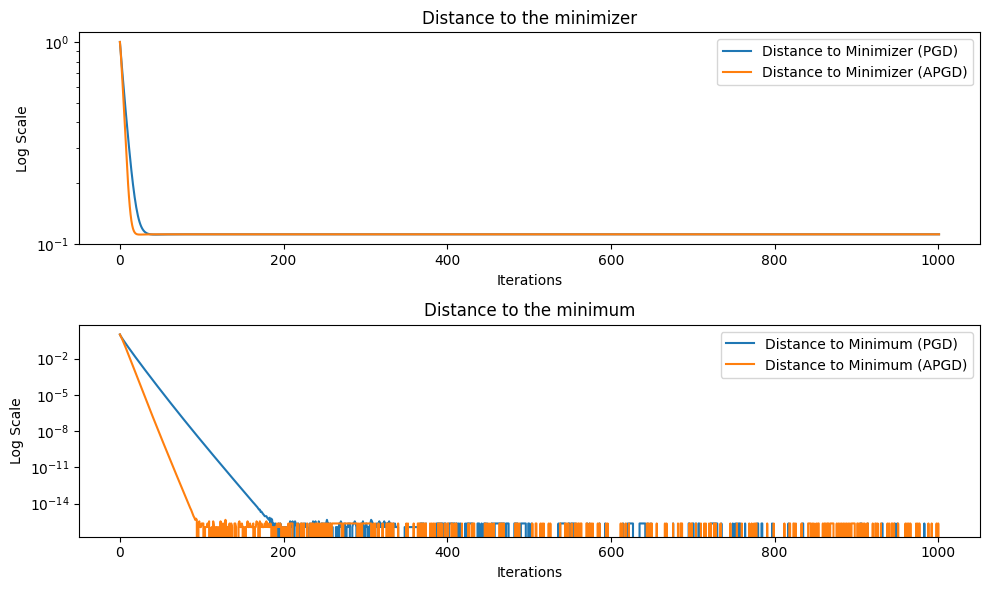

In [ ]:

#Computing PGD and APGD

x_pgd, obj_pgd, err_pgd = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2,
                            step, lmbd, n_iter, x_true=coefs, verbose=False)

x_apgd, obj_apgd, err_apgd = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2,
                               step, lmbd, n_iter, x_true=coefs, verbose=False)


# Compute distances to the minimum and minimizer for both PGD and APGD
dist_to_min_pgd = np.abs(obj_pgd - obj_pgd[-1])
dist_to_min_apgd = np.abs(obj_apgd - obj_apgd[-1])

# Create logarithmic scale plots
plt.figure(figsize=(10, 6))

# Convergence plot for distance to minimizers
plt.subplot(2, 1, 1)
plt.semilogy(err_pgd, label='Distance to Minimizer (PGD)')
plt.semilogy(err_apgd, label='Distance to Minimizer (APGD)')
plt.xlabel('Iterations')
plt.ylabel('Log Scale')
plt.legend()
plt.title('Distance to the minimizer')

# Convergence plot for APGD
plt.subplot(2, 1, 2)
plt.semilogy(dist_to_min_pgd, label='Distance to Minimum (PGD)')
plt.semilogy(dist_to_min_apgd, label='Distance to Minimum (APGD)')
plt.xlabel('Iterations')
plt.ylabel('Log Scale')
plt.legend()
plt.title('Distance to the minimum')

plt.tight_layout()
plt.show()



**Answer :** The convergence of APGD compared to PGD reveals that APGD achieves faster convergence, primarily due to the incorporation of momentum. Specifically, APGD converges at a rate of O(1/k^2), while PGD operates at O(1/k).
It's crucial to note that both of these algorithms, despite their differences in approach, prove to be valuable and relevant in specific contexts, depending on the function to minimize. This underscores the complexity of the optimization field, as discussed in class. Ultimately, this suggests that there is no one-size-fits-all algorithm for optimization; instead, an algorithm's suitability varies depending on the specific problem at hand.



<div class="alert alert-success">
    <b>EXERCISE</b>:
     <ul>
      <li>Compare the solution you obtain with PGD and APGD with the true parameter `coefs` of
  the model. This can be done with 3 `plt.stem` plots. Do this for one problem (linear or logistic), but for both regularizers. Comment.</li>
    <li> Pick one problem (logistic or linear) and regularizer (L1 or L2), and study the influence of the correlation
  of the features on the performance of the optimization algorithms. Explain.</li>
    <li>Pick a different problem (logistic or linear) and a different regularization (L1 or L2), and study the influence of the level of  
  penalization ($\lambda$) on the performance of the optimization algorithms. Explain. Analyse and explain the behavior of the solution vector when $\lambda$ increases.</li>
    </ul>
</div>

In [ ]:
# Reseting the parameters
x0 = np.zeros(n_features)
n_iter = 1000
lmbd = 5e-2

# Linear regression
A, b = simu_linreg(coefs)

# Smoothness
step = 1 / smoothness_const_linreg(A)

# Run PGD and APGD for Linear Regression with L1 Regularization
x_pgd_L1, obj_pgd_L1, err_pgd_L1 = PGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1,
                            step, lmbd, n_iter, x_true=coefs, verbose=False)

x_apgd_L1, obj_apgd_L1, err_apgd_L1 = APGD(x0, loss_linreg, grad_linreg, L1_norm, prox_L1,
                            step, lmbd, n_iter, x_true=coefs, verbose=False)

# Run PGD and APGD for Linear Regression with L2 Regularization
x_pgd_L2, obj_pgd_L2, err_pgd_L2 = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2,
                            step, lmbd, n_iter, x_true=coefs, verbose=False)

x_apgd_L2, obj_apgd_L2, err_apgd_L2 = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2,
                            step, lmbd, n_iter, x_true=coefs, verbose=False)



<ipython-input-17-daa96b723e53>:12: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[0][0].stem(pgd_solutions[0], linefmt='grey', use_line_collection=True)
<ipython-input-17-daa96b723e53>:18: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  ax[0][1].stem(pgd_solutions[1], linefmt='grey', use_line_collection=True)
<ipython-input-17-daa96b723e53>:24: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as ke

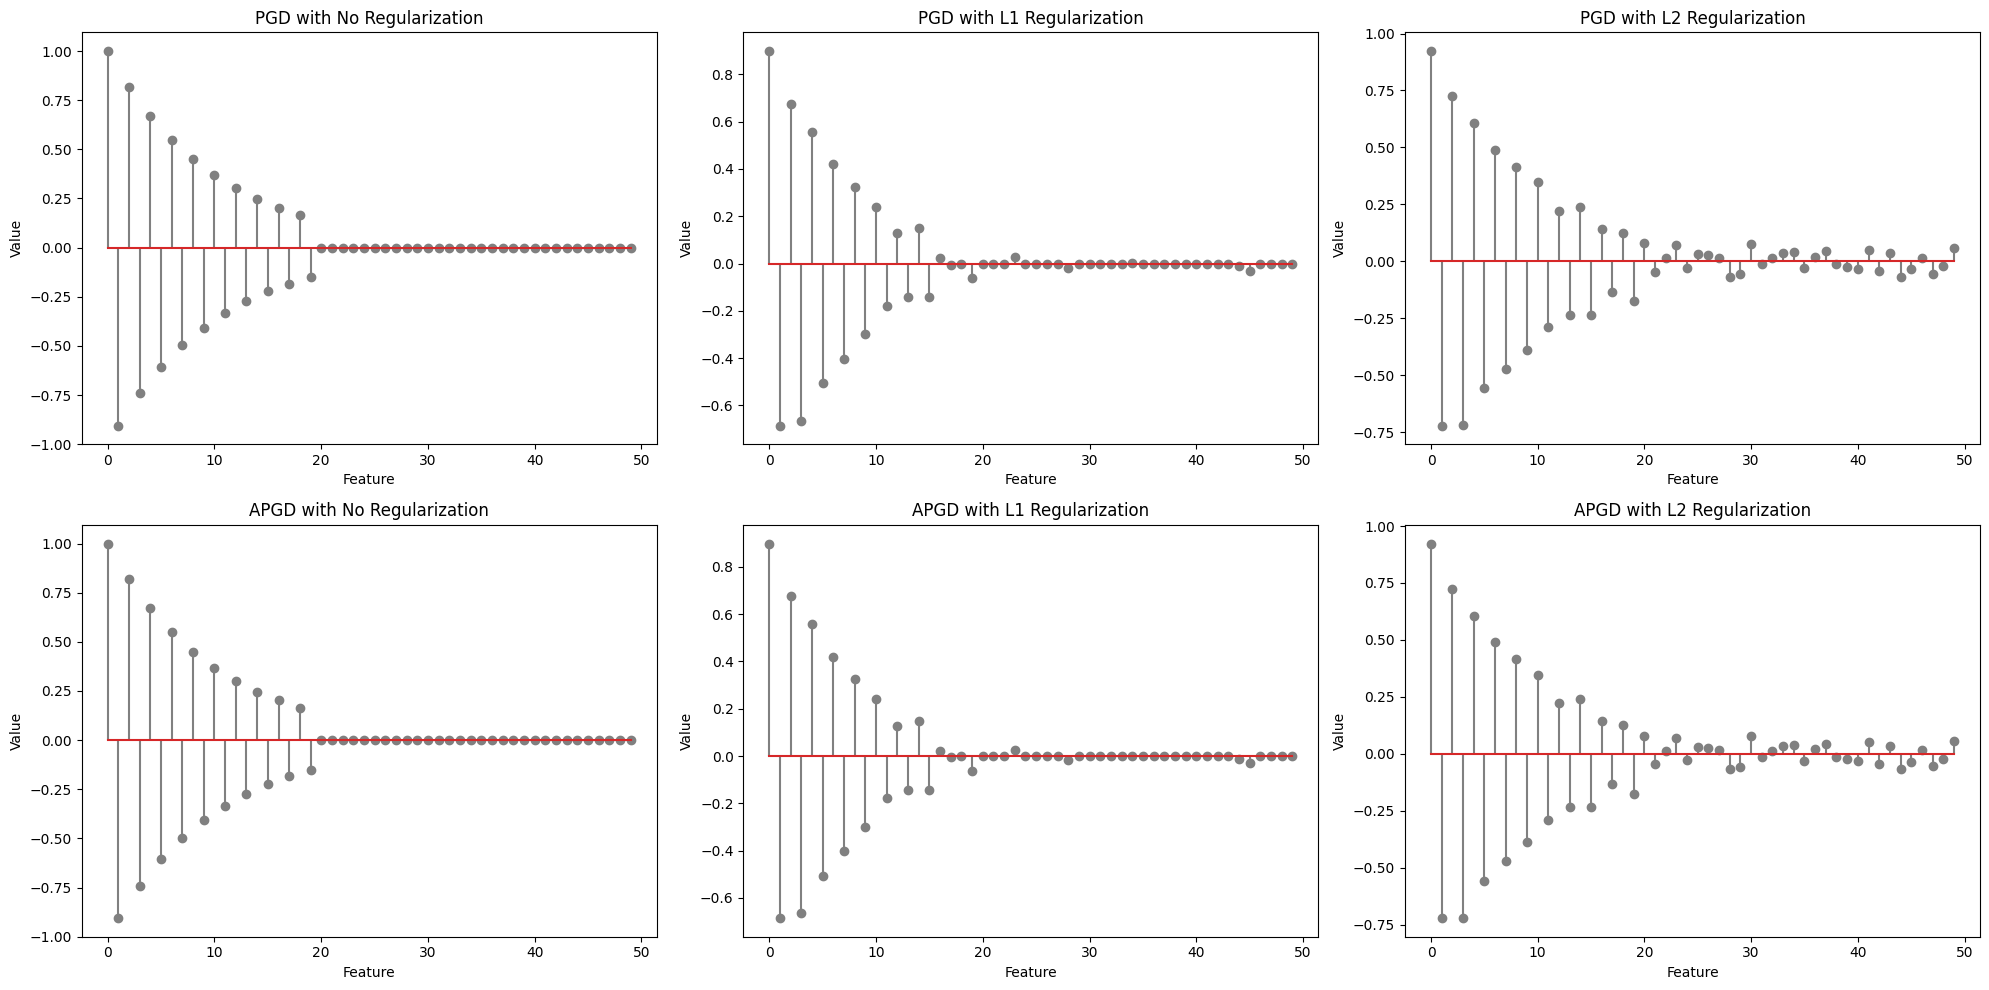

In [ ]:

# Create an array of labels for the regularization methods
reg_labels = ['No Regularization', 'L1 Regularization', 'L2 Regularization']

# Create a list of solution arrays for PGD and APGD for each regularization method
pgd_solutions = [coefs, x_pgd_L1, x_pgd_L2]
apgd_solutions = [coefs, x_apgd_L1, x_apgd_L2]

# Create subplots
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

# Set up the first subplot for PGD with No Regularization
ax[0][0].stem(pgd_solutions[0], linefmt='grey', use_line_collection=True)
ax[0][0].set_title('PGD with No Regularization')
ax[0][0].set_ylabel('Value')
ax[0][0].set_xlabel('Feature')

# Set up the second subplot for PGD with L1 Regularization
ax[0][1].stem(pgd_solutions[1], linefmt='grey', use_line_collection=True)
ax[0][1].set_title('PGD with L1 Regularization')
ax[0][1].set_ylabel('Value')
ax[0][1].set_xlabel('Feature')

# Set up the third subplot for PGD with L2 Regularization
ax[0][2].stem(pgd_solutions[2], linefmt='grey', use_line_collection=True)
ax[0][2].set_title('PGD with L2 Regularization')
ax[0][2].set_ylabel('Value')
ax[0][2].set_xlabel('Feature')

# Set up the fourth subplot for APGD with No Regularization
ax[1][0].stem(apgd_solutions[0], linefmt='grey', use_line_collection=True)
ax[1][0].set_title('APGD with No Regularization')
ax[1][0].set_ylabel('Value')
ax[1][0].set_xlabel('Feature')

# Set up the fifth subplot for APGD with L1 Regularization
ax[1][1].stem(apgd_solutions[1], linefmt='grey', use_line_collection=True)
ax[1][1].set_title('APGD with L1 Regularization')
ax[1][1].set_ylabel('Value')
ax[1][1].set_xlabel('Feature')

# Set up the sixth subplot for APGD with L2 Regularization
ax[1][2].stem(apgd_solutions[2], linefmt='grey', use_line_collection=True)
ax[1][2].set_title('APGD with L2 Regularization')
ax[1][2].set_ylabel('Value')
ax[1][2].set_xlabel('Feature')

# Show the plot
plt.tight_layout()
plt.show()

**Answer :** As suspected, the coeficients brought by both regularisation are close to the original coeficient.
However using a small Lambda there is no much difference between the PGD and APGD.



Now we're want to study the problem for logistic with regularization L1

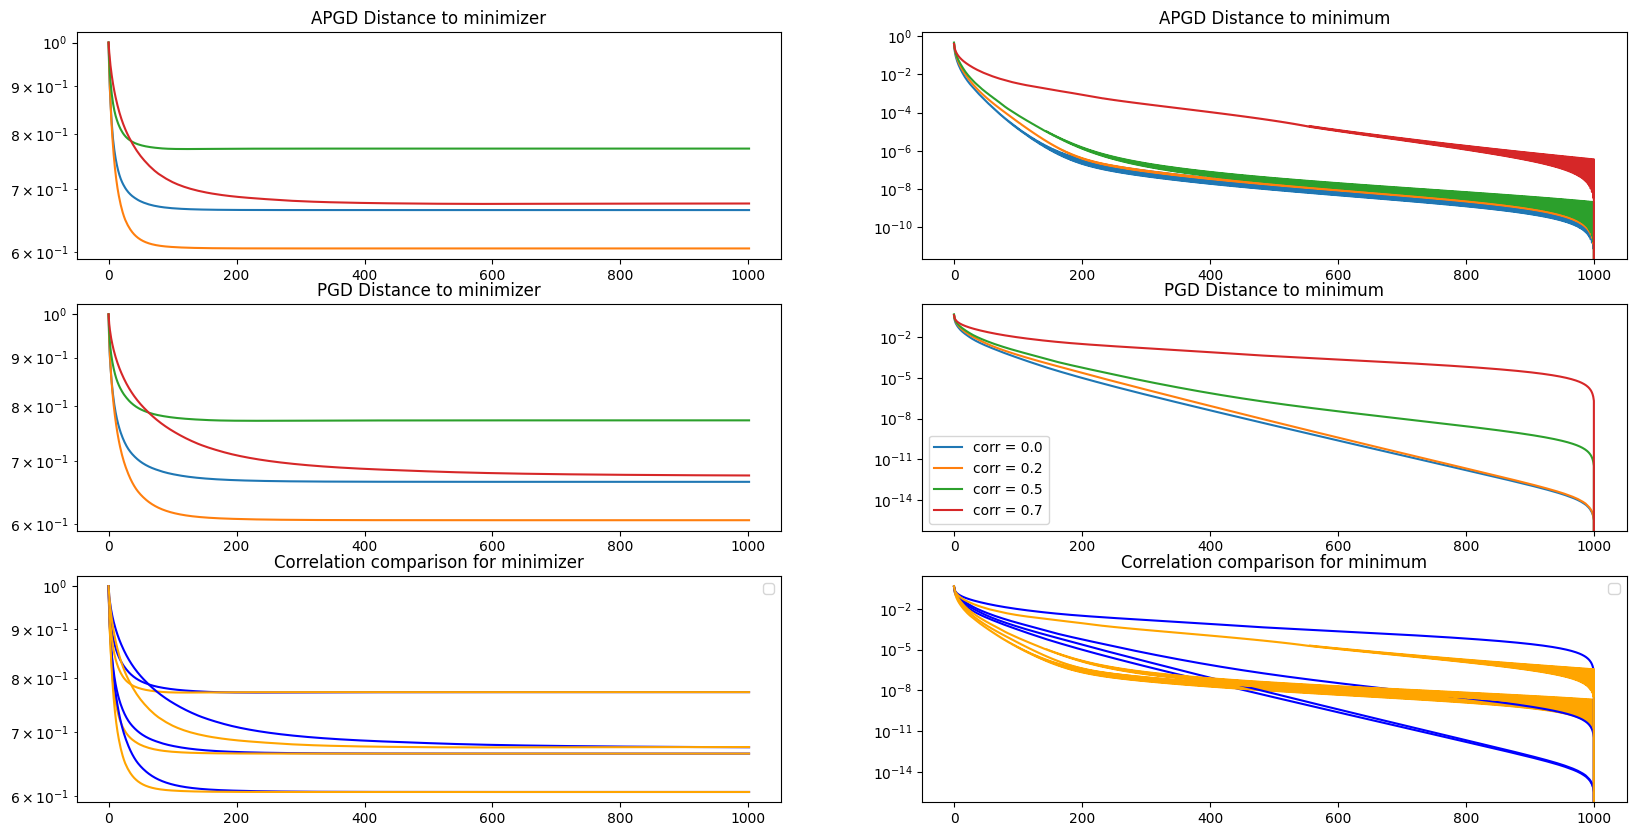

In [ ]:
# Set up parameters
n_samples = 100
n_features = 50
lmbd = 1e-2
fig, a = plt.subplots(3,2,figsize=(20,10))

# Vary the correlation of features
correlations = [0.0, 0.2, 0.5, 0.7]


# Loop through different levels of feature correlation
for corr in correlations:
    # Generate data with the specified correlation
    coefs = np.random.randn(n_features)
    A, b = simu_logreg(coefs, n_samples, corr)
    step = 1/smoothness_const_logreg(A)

    # Initialize x0 and other parameters
    x0 = np.zeros(n_features)

    # Use PGD and APGD to find the minimum and minimizer
    x_pgd_L1, obj_pgd_L1, x_pgd_err = PGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1,
                                step, lmbd, n_iter, x_true=coefs, verbose=False)
    x_apgd_L1, obj_apgd_L1, x_apgd_err = APGD(x0, loss_logreg, grad_logreg, L1_norm, prox_L1,
                                    step, lmbd, n_iter, x_true=coefs, verbose=False)

    # APGD Distance to Minimizer
    a[0,0].semilogy(x_apgd_err, label=f'corr = {corr}')
    # APGD Distance to Minimum
    a[0,1].semilogy(obj_apgd_L1 - obj_apgd_L1[-1], label=f'corr = {corr}')


    # PGD Distance to Minimizer
    a[1,0].semilogy(x_pgd_err, label=f'corr = {corr}')
    # PGD Distance to Minimum
    a[1,1].semilogy(obj_pgd_L1 - obj_pgd_L1[-1], label=f'corr = {corr}')

    # Comparison between APGD and PGD
    a[2,0].semilogy(x_pgd_err, color="blue")
    a[2,0].semilogy(x_apgd_err, color="orange")
    a[2,1].semilogy(obj_pgd_L1 - obj_pgd_L1[-1], color="blue")
    a[2,1].semilogy(obj_apgd_L1 - obj_apgd_L1[-1], color="orange")

a[0,0].set_title("APGD Distance to minimizer")
a[0,0].legend()
a[0,1].set_title("APGD Distance to minimum")
a[0,1].legend()
a[1,0].set_title("PGD Distance to minimizer")
a[1,0].legend()
a[1,1].set_title("PGD Distance to minimum")
a[1,1].legend()
a[2,0].set_title("Correlation comparison for minimizer")
a[2,0].legend()
a[2,1].set_title("Correlation comparison for minimum")
a[2,1].legend()



**Answer :** In the context of logistic regression with L1 regularization, it is often observed that correlated features can have a detrimental impact on the model's performance. This issue arises because multicollinearity can lead to highly variable and potentially unstable solutions, as discussed in a relevant post on Stack Exchange.

As the correlation between features increases, the singular values of the matrix $X^TX$ and the smoothness constant both experience significant growth, as they are closely related. Consequently, the step size decreases, inversely affecting the parameter L. This situation gives rise to several issues:

Algorithms become progressively less useful as feature correlations intensify.
The minimization process encounters higher values.
Convergence becomes slower.
By examining graphical representations, it becomes evident that the Alternating Proximal Gradient Descent (APGD) algorithm exhibits more pronounced oscillations compared to its Proximal Gradient Descent (PGD) counterpart, indicating a lower level of stability. This behavior can be attributed to the presence of momentum, similar to what is observed with Nesterov Accelerated Gradient (NAG), with APGD being a specific application of NAG.

Lastly, we will study the case for linear and L2 regularization.

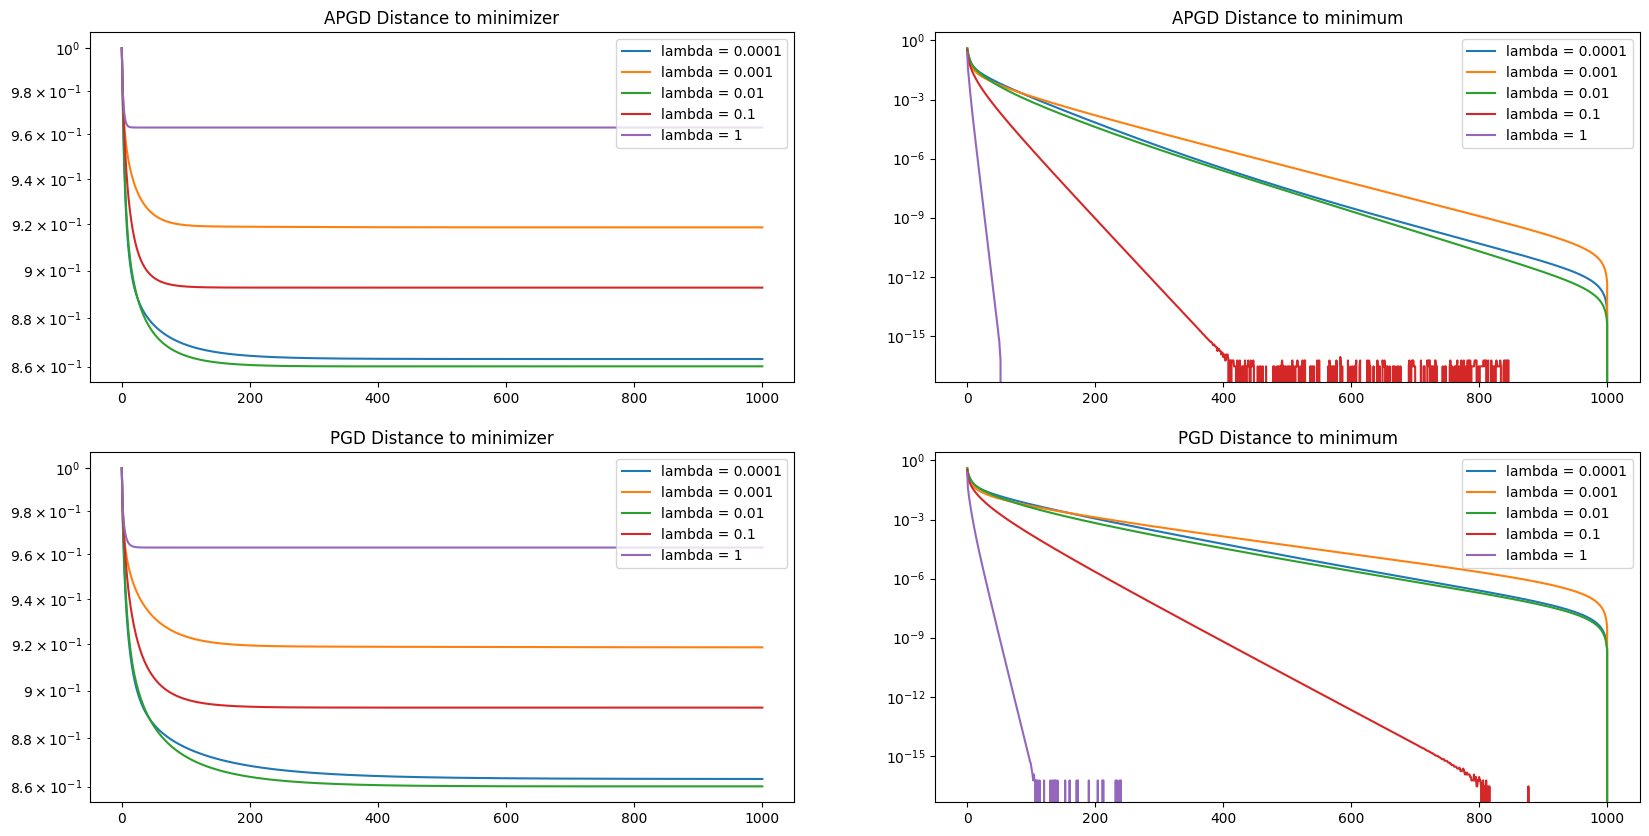

In [ ]:
# Set up parameters
n_samples = 100
n_features = 50
lmbd_values = [1e-4, 1e-3, 1e-2, 1e-1, 1]  # Varying lambda values
fig, a = plt.subplots(2,2,figsize=(20,10))

# Loop through different levels of feature correlation
for lmbd in lmbd_values:
    # Generate data with the specified correlation
    coefs = np.random.randn(n_features)
    A, b = simu_logreg(coefs, n_samples, corr)
    step = 1/smoothness_const_linreg(A)

    # Initialize x0 and other parameters
    x0 = np.zeros(n_features)

    # Use PGD and APGD to find the minimum and minimizer
    x_pgd_L1, obj_pgd_L1, x_pgd_err = PGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2,
                                step, lmbd, n_iter, x_true=coefs, verbose=False)
    x_apgd_L1, obj_apgd_L1, x_apgd_err = APGD(x0, loss_linreg, grad_linreg, L2_norm, prox_L2,
                                    step, lmbd, n_iter, x_true=coefs, verbose=False)

    # APGD Distance to Minimizer
    a[0,0].semilogy(x_apgd_err, label=f'lambda = {lmbd}')
    # APGD Distance to Minimum
    a[0,1].semilogy(obj_apgd_L1 - obj_apgd_L1[-1], label=f'lambda = {lmbd}')


    # PGD Distance to Minimizer
    a[1,0].semilogy(x_pgd_err, label=f'lambda = {lmbd}')
    # PGD Distance to Minimum
    a[1,1].semilogy(obj_pgd_L1 - obj_pgd_L1[-1], label=f'lambda = {lmbd}')



a[0,0].set_title("APGD Distance to minimizer")
a[0,0].legend()
a[0,1].set_title("APGD Distance to minimum")
a[0,1].legend()
a[1,0].set_title("PGD Distance to minimizer")
a[1,0].legend()
a[1,1].set_title("PGD Distance to minimum")
a[1,1].legend()




**Answer :** From a visual standpoint, it seems that decreasing the λ value allows the algorithm to discover a more favorable minimum. However, it's crucial to recognize that, in contrast to the initial impression, there exists a specific threshold for λ as it diminishes, effectively hindering further improvements by the algorithm. This threshold is likely situated around λ = 0.001, given that the green curve most likely represents the optimal iteration in our dataset.

What causes diminished performance when λ is set either too high or too low?

Let's consider constants B and C, where B and C are positive real numbers.

In the scenario where λ is excessively high (λ > B ≈ 0.01), the L2 Penalization component bears excessive weight in the equation. The algorithm primarily focuses on optimizing the regularization, thus introducing a bias in optimization and, consequently, resulting in subpar performance.

Conversely, when λ is exceedingly low (λ < C ≈ 0.001), the impact of the L2 Penalization becomes negligible. This hinders the algorithm from capitalizing on the regularization's intended benefits, such as rendering the function convex, which, in turn, obstructs the minimization process.